# ДЗ №5 Сегментация
Реализация сети для сегметации объектов.

__Задача__ сделать работоспособную сеть для сегментирования изображений авто на основе предложенного шаблона


![Segmentation](../img/Segment04.png)

### Что делаем
Реализуем сверточную сеть для семантической сегментации, downsample->upsample -> Классификация каждого пикселя выходного изображения: 0 - не авто, 1 - авто. Выход картинка с x каналами, для классификации.
1. В файле model.py   - имплементировать модель вместо заглушки
2. В файле train.py - поставить правильный loss

### Данные
[Carvana](https://cloud.mail.ru/public/3tdq/AvtaHkDAb)

### Зависимости
 - tensorflow  - поддержка tensorboard
 - tensorboardx - тензор боард для pytorch
 - tqdm         - пакет для отрисовки прогресс баров

### Запуск пакета
_ По умолчанию все данные лежат в папке ./data/. Если вы положили их в другую папку, то поправте в скрипте train.py пути _
<br/>
Запускаем обучение сети
python train.py

Результаты обучение можно наблюдать в tensorboard

Запуск tensorboard --log ./od_log

## Результаты
1. Код model.py, train.py
2. Модель state_dicts()

### Тут нужно сделать загрузку состояния вашей модели, код модели в ноутбук тащить не нужно, достаточно сделать import model


In [1]:
%matplotlib inline

In [2]:
import torch.nn as nn
import torch
import matplotlib.pyplot as plt

In [3]:
# Загружаем модель 
from model import SegmenterModel

In [4]:
m = SegmenterModel()
m.load_state_dict(torch.load('model_state_dict_CrossEntropyLoss.pth.tar'))
m.eval()

SegmenterModel(
  (conv1): Conv2d(3, 16, kernel_size=(11, 11), stride=(2, 2), padding=(5, 5))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout2d(p=0.2)
  (high_res1_down): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (dropout2): Dropout2d(p=0.2)
  (high_res2_down): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (dropout3): Dropout2d(p=0.2)
  (conv2): Conv2d(16, 32, kernel_size=(11, 11), stride=(2, 2), padding=(5, 5))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout2d(p=0.2)
  (middle_res1_down): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), s

In [5]:
from carvana_dataset import CarvanaDataset
import torch.utils.data as dt
from tqdm import *
## Реализуем тест модели на тестовом сете
## замеряем среднюю метрику по тестовому сету, пример кода есть в train.py

In [6]:
test = './data/test/'
test_masks = './data/test_masks'
useCuda = True
criterion = nn.BCELoss()
if useCuda == True:
    m = m.cuda()
    criterion= criterion.cuda()
ds_test = CarvanaDataset(test, test_masks)
dl_test = dt.DataLoader(ds_test, shuffle=False, num_workers=4, batch_size=5)
test_loss = 0
m.eval()
for iter, (i, t) in enumerate(tqdm_notebook(dl_test)):
            with torch.no_grad():
                if useCuda :
                    i = i.cuda()
                    t = t.cuda()
                o = m(i)
                tmp = torch.cat((t, 1.-t), dim=1)
                if useCuda :
                    tmp = tmp.cuda()
                loss = criterion(o, tmp)
                test_loss += loss.item()

test_loss = test_loss / float(len(ds_test))
print ("Test loss", test_loss)


Test loss 0.015042223410284895


### Тут нужно нарисовать картинки, с результатими сегментации из тестового сета

In [7]:
import random
random.seed()

In [8]:
idx = random.randint(0, len(ds_test))

In [9]:
# Для рандомного изображения рисуем его маску сгенерированную сеткой, само изображение и результат сегментации
t_image, t_image_mask = ds_test[idx]
if useCuda == True:
    t_image = t_image.cuda()
    t_image_mask = t_image_mask.cuda()

### Исходное изображение

In [10]:
from torchvision.transforms import ToPILImage
to_img = ToPILImage()

torch.Size([3, 224, 224])


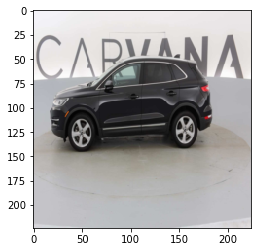

In [11]:
print(t_image.size())
img = to_img(t_image.detach().cpu())
plt.imshow(img)

### Маска, сгенерированная сеткой

torch.Size([224, 224])


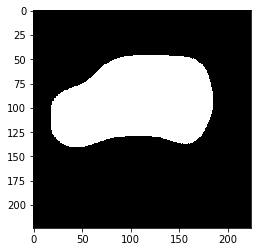

In [12]:
o_image = m(t_image.unsqueeze(0)).chunk(2, dim=1)[0].squeeze(0).squeeze(0).cpu()
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
print(o_image.size())
plt.imshow(o_image.detach().numpy(), cmap='gray')

### Тестовая маска

In [13]:
t_image_mask = t_image_mask.squeeze(0)

torch.Size([224, 224])


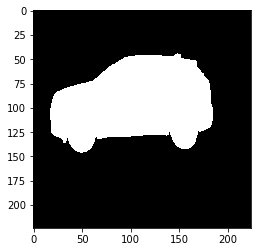

In [14]:
print(t_image_mask.size())
plt.imshow(t_image_mask.detach().cpu().numpy(), cmap='gray')